# Libraries

In [1]:
import numpy as np
import pystan
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [4]:
# Main thread

if __name__ == '__main__':

    # Configuring paths and inputs -------------------------------------------------------------------------------------
    my_data = np.loadtxt('./../Catalogue/binom_reg_dataset.csv', delimiter=',', dtype=str)

    my_dictionary = {}
    for i in range(len(my_data[0, :])):                                         # Converting numpy array into dictionary
         my_dictionary[my_data[0, i]] = np.array(my_data[0 + 1:, i], dtype=str)

    logit_class   = my_dictionary['LOGIT_CLASS(1-UVUP;0-UVWEAK)'].astype(int)
    redshift      = my_dictionary['Z'].astype(float)
    stellar_mass  = my_dictionary['STELLAR_MASS'].astype(float)
    
    index = np.where(redshift<=0.4)

    x1 = redshift[index]
    x2 = stellar_mass[index]
    y  = logit_class[index]                                             # whether this is a galaxy with uv upturn or not
    n_obs = x1.size

    regression_data = {}
    regression_data['K'] = 4      # number of betas
    regression_data['X'] = sm.add_constant(np.column_stack((x1, x1**2,x2)))
    # regression_data['X'] = sm.add_constant(x1)
    regression_data['N'] = n_obs
    regression_data['Y'] = y
    regression_data['LogN'] = np.log(n_obs)
    
    # Data to be plotted -------------------------------------------------------------------------------------------
#     redshift_plot = np.linspace(x1.min(), x1.max(), 1000)
#     x2 = redshift_plot
#     n_obs2 = redshift_plot.size
#     regression_data['X2'] = sm.add_constant(np.column_stack((x2, x2**2)))
#     regression_data['N2'] = n_obs2

    # Fit: STAN code ---------------------------------------------------------------------------------------------------
    stan_code = """
    data{
        int<lower=0> N;
        int<lower=0> K;
        int Y[N];
        matrix[N,K] X;
        real LogN;
    }

    parameters{
        vector[K] beta;
    }

    transformed parameters{
        vector[N] eta;
        eta = X * beta;
    }

    model{
        Y ~ bernoulli_logit(eta);
    }

    generated quantities{
        real LLi[N];
        real AIC;
        real BIC;
        real LogL;
        vector[N] etanew;
        real<lower=0, upper=1.0> pnew[N];
        etanew = X * beta;
        for (j in 1:N){
            pnew[j] = inv_logit(etanew[j]);
            LLi[j] = bernoulli_lpmf(1|pnew[j]);
        }
        LogL = sum(LLi);
        AIC = -2 * LogL + 2 * K;
        BIC = -2 * LogL + LogN * K;
    }
    """

    fit = pystan.stan(model_code=stan_code, data=regression_data, iter=7000, chains=3, warmup=3000, n_jobs=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_380fcba733f6f2ec51b21114e52c2444 NOW.


In [5]:
lines = list(range(8)) + [2 * n_obs + 8, 2 * n_obs + 9, 2 * n_obs + 10]
output = str(fit).split('\n')

for i in lines:
    print(output[i])

Inference for Stan model: anon_model_380fcba733f6f2ec51b21114e52c2444.
3 chains, each with iter=7000; warmup=3000; thin=1; 
post-warmup draws per chain=4000, total post-warmup draws=12000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta[0]      -4.75    0.07   4.37  -13.6  -7.62  -4.75  -1.77   3.62 3558.0    1.0
beta[1]      20.82    0.17  10.02   1.32   14.2  20.55   27.5  41.03 3511.0    1.0
beta[2]     -41.24    0.39  23.73 -88.07  -57.2 -40.61 -25.25   4.89 3636.0    1.0
LLi[503]     -0.75  8.5e-4   0.07  -0.89   -0.8  -0.75  -0.71  -0.63 5973.0    1.0
AIC         925.58    0.55   56.7  817.9 886.75 924.11 962.87 1040.4  10770    1.0
BIC         942.47    0.55   56.7 834.79 903.64  941.0 979.76 1057.3  10770    1.0


In [6]:
output = str(pystan.misc._print_stanfit(fit, digits_summary=4)).split('\n')

In [7]:
posteriors = list(fit.extract(u'beta').items()[0])

In [8]:
betas = posteriors[1]

In [9]:
print betas.shape

(12000, 4)


In [10]:
beta0 = betas[:,0]
beta1 = betas[:,1]
beta2 = betas[:,2]
beta3 = betas[:,3]

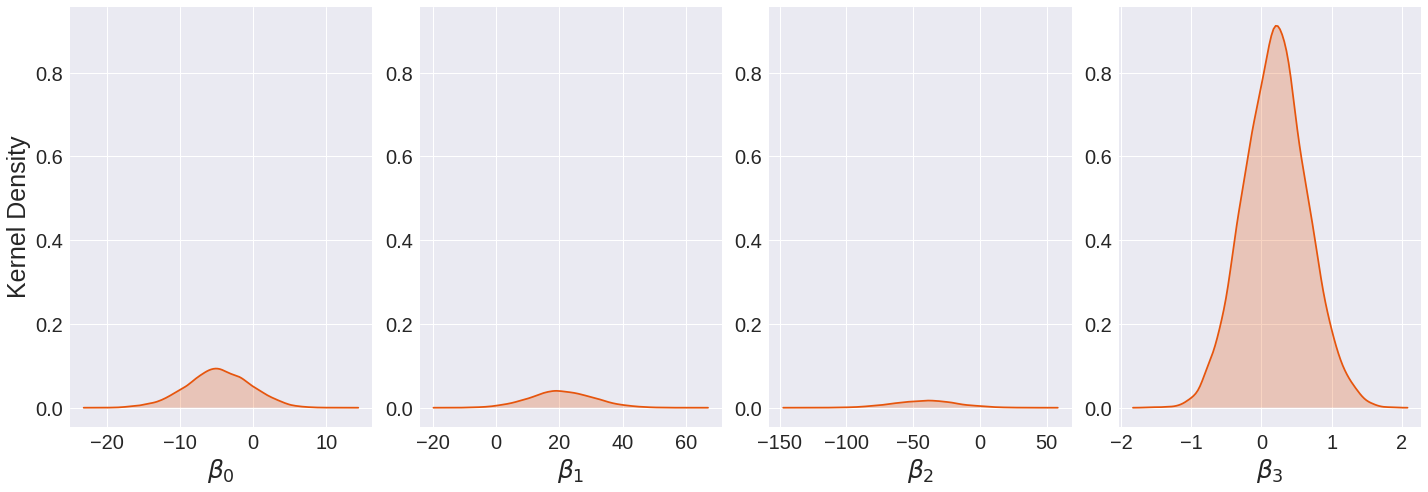

In [15]:
plt.subplots(1,1, figsize=(20,7), sharey=True)

plot01 = plt.subplot(1,4,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,2, sharey=plot01)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,3, sharey=plot01)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,4, sharey=plot01)
sns.kdeplot(beta3, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{3}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
# plt.savefig('./Model/posterios_sharey_3d.pdf', dpi=100)
plt.show()

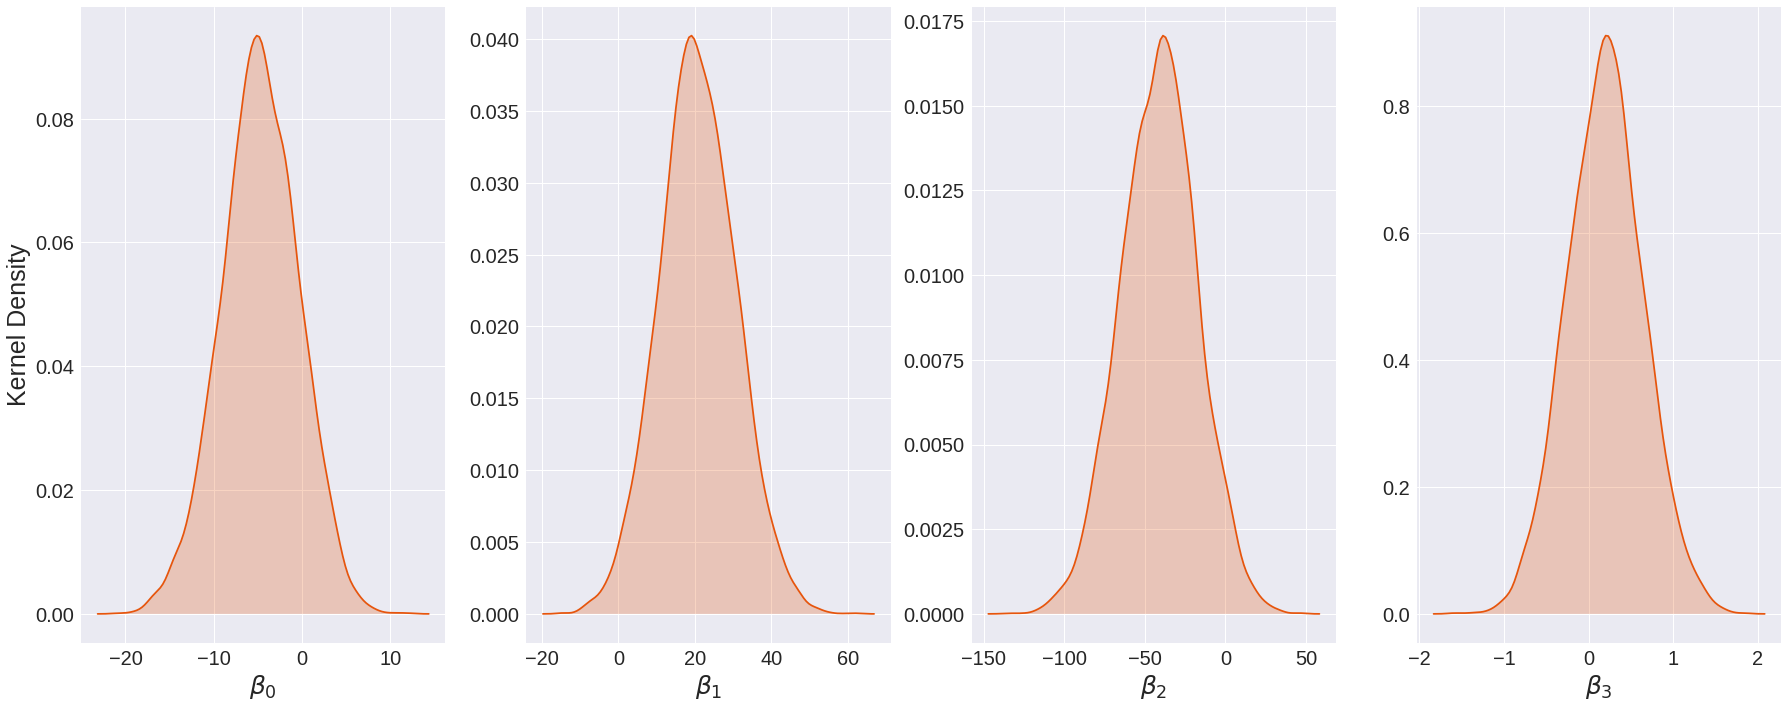

In [14]:
plt.subplots(1,1, figsize=(25,10), sharey=True)

plot01 = plt.subplot(1,4,1)
sns.kdeplot(beta0, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{0}$", fontsize=25)
plt.ylabel(r"Kernel Density", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,2)
sns.kdeplot(beta1, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{1}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,3)
sns.kdeplot(beta2, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{2}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.subplot(1,4,4)
sns.kdeplot(beta3, shade=True, c='#e6550d')
plt.xlabel(r"$\beta_{3}$", fontsize=25)
plt.tick_params('both', labelsize='20')

plt.tight_layout()
# plt.savefig('./Model/posterios_3d.pdf', dpi=100)
plt.show()

In [16]:
output = np.array(output)

In [17]:
new_output = output[5:-6] #removing header and footer
print new_output.shape
print new_output.size
print new_output[0].split()[0]

(2023,)
2023
beta[0]


In [22]:
for i in range(new_output.size):
    print new_output[i]
# print new_output[-1]
# print new_output[9610]
# print new_output[-2]
# print new_output[4725].split()[1][0:6]
# print new_output[4725].split()[1][6:]

beta[0]     -4.748  0.0732 4.3671 -13.60 -7.620 -4.747 -1.767 3.6231   3558 1.0003
beta[1]     20.815  0.1692 10.024 1.3208 14.195 20.552 27.504 41.027   3511 1.0005
beta[2]     -41.23  0.3936 23.730 -88.07 -57.20 -40.61 -25.25 4.8943   3636 1.0003
beta[3]     0.2007  0.0077 0.4506 -0.681 -0.105 0.2016 0.4964 1.0977   3458 1.0005
eta[0]      -0.677  0.0033 0.2171 -1.113 -0.821 -0.674 -0.530 -0.262   4364 1.0001
eta[1]      -0.487  0.0017 0.1388 -0.759 -0.582 -0.487 -0.392 -0.218   7007 1.0004
eta[2]      -0.209  0.0015 0.1218 -0.446 -0.290 -0.208 -0.126 0.0257   6748 1.0001
eta[3]      -0.106   0.002 0.1397 -0.381 -0.200 -0.103 -0.012 0.1681   4890 1.0002
eta[4]      -0.389  0.0024 0.1597 -0.707 -0.494 -0.388 -0.283 -0.079   4581 1.0002
eta[5]      -0.283  0.0014 0.1152 -0.510 -0.359 -0.281 -0.204  -0.06   6888 1.0001
eta[6]      0.0379  0.0017 0.1416 -0.241 -0.056 0.0381 0.1336 0.3178   6551    1.0
eta[7]      0.0044  0.0036 0.2939 -0.579 -0.190 0.0065 0.2024 0.5733   6731    1.0
eta[

etanew[471] -0.672  0.0013 0.1283 -0.926 -0.755 -0.670 -0.587 -0.421  10470    1.0
etanew[472] -0.074  0.0021 0.1439 -0.357 -0.171 -0.071 0.0222 0.2107   4852 1.0002
etanew[473] -0.146  0.0019 0.1363 -0.414 -0.238 -0.144 -0.054 0.1214   4939 1.0002
etanew[474] -0.029  0.0039  0.312 -0.646 -0.238 -0.028 0.1826 0.5793   6371 0.9999
etanew[475] -0.278  0.0014 0.1147 -0.505 -0.355 -0.277 -0.199 -0.055   7178 1.0001
etanew[476] 0.0076  0.0021 0.1572 -0.303 -0.098 0.0068 0.1148 0.3173   5731 1.0001
etanew[477] -0.392  0.0012 0.1149 -0.618 -0.471 -0.391 -0.313 -0.168   8877 1.0002
etanew[478] -0.072  0.0016 0.1284 -0.326 -0.158 -0.070  0.016 0.1799   6238    1.0
etanew[479] -0.127  0.0034 0.2093 -0.539 -0.267 -0.126 0.0122 0.2849   3903 1.0004
etanew[480] -1.008  0.0039 0.2642 -1.546 -1.183 -1.002 -0.827 -0.510   4700 0.9999
etanew[481] -0.342  0.0022 0.1524 -0.642 -0.443 -0.340 -0.240 -0.045   4621 1.0002
etanew[482] -0.693  0.0018 0.1516 -0.991 -0.793 -0.690 -0.591 -0.405   6823 0.9999
etan

In [23]:
print new_output.shape

(2023,)


In [24]:
diagnostics = []
for i in range(new_output.size):
    if len(new_output[i].split())<11:
        print i, len(new_output[i].split()),'\n'
        print new_output[i].split(), len(new_output[i].split())
        diagnostics.append(len(new_output[i].split()))
    else:
        continue
print np.unique(diagnostics)

435 10 

['eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', '-0.1459.198e-5', '6845', '1.0001'] 10
1012 7 

['AIC', '9.256e2', '0.5464', '56.7018.179e28.868e29.241e29.629e2', '1.04e3', '10770', '1.0001'] 7
1013 7 

['BIC', '9.425e2', '0.5464', '56.7018.348e29.036e2', '9.41e29.798e21.057e3', '10770', '1.0001'] 7
1014 6 

['LogL', '-4.588e2', '0.2732', '28.350-5.162e2-4.774e2-4.581e2-4.394e2-4.049e2', '10770', '1.0001'] 6
1446 10 

['etanew[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', '-0.1459.198e-5', '6845', '1.0001'] 10
[ 6  7 10]


In [25]:
header_fit = output[4].split()
print header_fit

['mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [26]:
header_addendum = 'parameter'
header_fit = [header_addendum] + header_fit
print header_fit

['parameter', 'mean', 'se_mean', 'sd', '2.5%', '25%', '50%', '75%', '97.5%', 'n_eff', 'Rhat']


In [136]:
# this is to fix lines where numbers are not separated - which is the case of positions 2 and 3 many times
new_data = header_fit
for i in range(new_output.size):
    if len(new_output[i].split())==11: #the length of the list must be 11, in which case we connect them directly
        new_output_i = np.array(new_output[i].split()).reshape(1,11)
        new_data = np.vstack((new_data, new_output_i))
        
    elif len(new_output[i].split())==10:
        list_temp = new_output[i].split()
        for j in range(len(list_temp)):
            if len(list_temp[j])>11:
                print  j, list_temp[j]
                position_01 = list_temp[j][:-8]
                position_02 = list_temp[j][-8:]
                new_list_temp.append([position_01, position_02])
                print new_list_temp
#             else:
#                 new_list_temp.append(list_temp[j])
#             print new_list_temp
        fixed_row = np.array(new_list_temp)
        fixed_row = fixed_row.reshape(1,11)
        new_data = np.vstack((new_data, fixed_row))
            
            
             
            
            
#             if list_temp[0][0:3] == 'eta':
#                 if j==7:
#                     print list_temp[j]
#                     new_list_temp.append(list_temp[j][0:8])    #1
#                     new_list_temp.append(list_temp[j][8:14])   #2
#                     new_list_temp.append(list_temp[j][14:20])  #3
#                     new_list_temp.append(list_temp[j][20:26])  #4
#                     new_list_temp.append(list_temp[j][26:32])  #5
#                     new_list_temp.append(list_temp[j][32:38])  #6
#                     new_list_temp.append(list_temp[j][38:43])  #7
#                     new_list_temp.append(list_temp[j][43:49])  #8
#                     new_list_temp.append(list_temp[j][50:58])  #9
#                 else:
#                     new_list_temp.append(list_temp[j])
#                 print new_list_temp

#             elif list_temp[0] == 'LogL':
#                 if j==2:
#                     new_list_temp.append(list_temp[j][0:6])
#                     new_list_temp.append(list_temp[j][6:13])
#                     new_list_temp.append(list_temp[j][13:21])
#                     new_list_temp.append(list_temp[j][21:29])
#                     new_list_temp.append(list_temp[j][29:37])
#                     new_list_temp.append(list_temp[j][37:45])
#                     new_list_temp.append(list_temp[j][45:53])
#                 else:
#                     new_list_temp.append(list_temp[j])
#             print new_list_temp
#         fixed_row = np.array(new_list_temp)
#         fixed_row = fixed_row.reshape(1,11)
#         new_data = np.vstack((new_data, fixed_row))
        
#     elif len(new_output[i].split())==6:
#         list_temp = new_output[i].split()
#         new_list_temp = []
#         for j in range(len(list_temp)):
#             if j==2:
#                 new_list_temp.append(list_temp[j][0:6])
#                 new_list_temp.append(list_temp[j][6:13])
#                 new_list_temp.append(list_temp[j][13:20])
#                 new_list_temp.append(list_temp[j][20:27])
#                 new_list_temp.append(list_temp[j][27:34])
#                 new_list_temp.append(list_temp[j][34:41])
#             else:
#                 new_list_temp.append(list_temp[j])
#             print new_list_temp 
#         fixed_row = np.array(new_list_temp)
#         fixed_row = fixed_row.reshape(1,11)
#         new_data = np.vstack((new_data, fixed_row))
        

#     elif len(new_output[i].split())==7: # if the length is 10, we must split these lines
#         list_temp = new_output[i].split()
#         new_list_temp = []
#         for j in range(len(list_temp)):
#             if list_temp[0] == 'LogL':
#                 if j==4:
#                     new_list_temp.append(list_temp[j][0:6])
#                     new_list_temp.append(list_temp[j][6:14])
#                     new_list_temp.append(list_temp[j][14:21])
#                     new_list_temp.append(list_temp[j][21:29])
#                     new_list_temp.append(list_temp[j][29:37])
#                     new_list_temp.append(list_temp[j][37:45])
#                     new_list_temp.append(list_temp[j][45:53])
                    
#             if j==1:
#                 if (list_temp[j][0:6][-1]=='.'): 
#                     new_list_temp.append(list_temp[j][0:4])
#                     new_list_temp.append(list_temp[j][4:])
#                 elif list_temp[j][6:][0]=='.':
#                     new_list_temp.append(list_temp[j][0:5])
#                     new_list_temp.append(list_temp[j][5:])
#                 else:
#                     new_list_temp.append(list_temp[j][0:6])
#                     new_list_temp.append(list_temp[j][6:])
#             elif list_temp[0] == 'AIC':
#                 if j==4:
#                     new_list_temp.append(list_temp[j][0:6])
#                     new_list_temp.append(list_temp[j][6:13])
#                     new_list_temp.append(list_temp[j][13:20])
#                     new_list_temp.append(list_temp[j][20:27])
#                     new_list_temp.append(list_temp[j][27:34])
#             else:
#                 new_list_temp.append(list_temp[j])
#             print new_list_temp 
#         fixed_row = np.array(new_list_temp)}
#         fixed_row = fixed_row.reshape(1,11)
#         new_data = np.vstack((new_data, fixed_row))

#             else:
#                 new_list_temp.append(list_temp[j])
        print new_list_temp
        fixed_row = np.array(new_list_temp)
        fixed_row = fixed_row.reshape(1,11)
        new_data = np.vstack((new_data, fixed_row))

7 -0.1459.198e-5
['eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', '-0.145', '9.198e-5', '6845', '1.0001', 'etanew[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', '-0.145', '9.198e-5', '6845', '1.0001', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', '-0.145', '9.198e-5', '6845', '1.0001', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', ['-0.145', '9.198e-5'], '6845', '1.0001', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', ['-0.145', '9.198e-5'], '6845', '1.0001', 'eta[431]', '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', ['-0.145', '9.198e-5'], '6845', '1.0001', ['', 'eta[431]'], '-0.227', '0.0014', '0.1182', '-0.458', '-0.306', '-0.226', ['-0.145', '9.198e-5'], '6845', '1.0001', ['', 'eta[431]'], ['', 'eta[431]'], [

ValueError: cannot set an array element with a sequence

In [91]:
import pandas as pd

In [ ]:
new_dataframe = pd.DataFrame(new_data)
new_dataframe.to_csv('./Model/fit_results_3d.csv', sep=',', header=False, index=False)

In [ ]:
print new_data.shape
print new_data[-1]

In [ ]:
betas = {}
betas['beta0'] = beta0
betas['beta1'] = beta1
betas['beta2'] = beta2
betas['beta3'] = beta3

In [ ]:
betas_dataframe = pd.DataFrame(betas)
betas_dataframe.to_csv('./Model/betas_3d.csv', sep=',', header=True, index=False)

In [ ]:
pnew = list(fit.extract(u'pnew').items()[0])

In [ ]:
model_results = {}
model_results['pnew'] = pnew[1][0]
model_results['redshift'] = x1
model_results['SERSIC_GALFIT'] = x2
model_results['SERSIC_SEXTRACTOR'] = sersic_sex[index] 

In [ ]:
model_dataframe = pd.DataFrame(model_results)
model_dataframe.to_csv('./Model/model_prob_3d.csv', sep=',', header=True, index=False)